# Empirical Orthogonal Function Analysis

EOF analysis provides a simple and efficient means of evaluating the dominant modes of variability contained in a dataset. It is done by moving to a new mathematical basis which relates to the covariance of the data, and then focusing the analysis effort on the basis vectors that describe the majority of the variance. It is <u>Principal Component Analysis</u> applied to spatio-temporal data.

This code calculates both spatial and temporal eigenvectors (also known as eigenfunctions or EOFs) that describe the variance of a spatio-temporal dataset (e.g. shoreline position data along  a beach). 

The aim is to describe the datasets variability across both space and time with new basis functions. These are purely mathematic functions (eigenfunctions) but can sometimes relate closely to physical processes. Also, there is some research suggesting a relationship between alongshore and cross-shore transport processes and the shape of the eigenfunctions;
- extrema in the spatial eigenfunctions relates to areas of maximum variability,
- nodal points in the spatial eigenfunctions relates to areas of stability (low variability),
- multiple nodal points in the spatial eigenfunction may indicate the importance of longshore processes,
- spatial eigenfunctions without nodes can describe shoreline response to cross-shore processes (i.e. the entire coast advances/retreats in phase).

A full positive/negative spatial eigenfunction implies that if erosion (or accretion) is occurring at one location, erosion (or accretion) is also occurring at every other location. Gradients in this eigenfunction can imply a different rate of erosion/accretion.

See per Miller & Dean (2006, 2007): Shoreline variability via EOF analysis - https://doi.org/10.1016/j.coastaleng.2006.08.013.
This method has been used since by Harley et al. (2011) - https://doi.org/10.1029/2011JF001989 - to show that cross-shore processes are an important mode of variability in beach rotation.

Other useful references (EOFs or Principal Component Analysis):
- http://stockage.univ-brest.fr/~herbette/Data-Analysis/data_analysis_eof.pdf
- https://towardsdatascience.com/the-mathematics-behind-principal-component-analysis-fff2d7f4b643
- https://www.cygres.com/OcnPageE/Glosry/OcnEof1E.html

## 1 - Import Python Modules

In [1]:
# import packages and modules
import numpy as np
import os
import pandas as pd # package for working with tabular data in DataFrames
import matplotlib.pyplot as plt # plotting package
import datetime
import seaborn as sns # for plotting DataFrames (tabular data)
import scipy.stats as sst # For pearson correlation coefficients (linear test of correlation)
# System check
import sys
print('Python version:', sys.version,
      '\nAnaconda environment:', sys.executable)

Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)] 
Anaconda environment: C:\Users\s5245653\Anaconda3\python.exe


In [2]:
def Month2Season(df):
    season_dict = {1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
                   6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10:'Spring',
                   11: 'Spring', 12: 'Summer'}
    season_val_dict = {'Summer': 1.0, 'Autumn': 2.0, 'Winter': 3.0, 'Spring': 4.0}
    df['Season'] = df['Month'].apply(lambda x: season_dict[x])
    df['Season_Val'] = df['Season'].apply(lambda x: season_val_dict[x])
    return df

## 2 - User Inputs

In [3]:
# Set and Check Directory
dataDir = 'C:/Users/s5245653/OneDrive - Griffith University/Projects/NaturalShorelineVariability_Grassy/data/'
plotDir = 'Plots/All/EOFs/'
os.chdir(dataDir)

# User inputs
resamplePeriod = '1MS' # see Pandas documentation for frequency choices for resampling (e.g. monthly - '1MS')
transectSpacing = 50 # metres
inputFile = dataDir + 'SAM_neg.csv'
idxCol = 'dates' # index column in csv data (needs to be datetime)
minVarianceOfInterest = 10 # percent
firstDate = datetime.datetime(1987, 9, 1, tzinfo=datetime.timezone.utc) # year, month, day
lastDate = datetime.datetime(2020, 12, 31, tzinfo=datetime.timezone.utc)

# Plots
figSize = [10,6] # figure size in inches
resolution = 600 # dpi
yTitle = 'EOF' 
xTitle = 'Alongshore Distance From West (m)'
labelLoc = 'upper left'

yRange = [-0.55, 0.55] # Spatial EOF
yRangeTemp = [-0.199, 0.199] # Temporal EOF
plotName = dataDir + plotDir + f'{yTitle}_RSP_SAM_Neg.jpg'

# Second Plot
colTitles = ['Spatial', 'Temporal']
labelLetters = [['a)', 'b)'], ['c)', 'd)']]
plot2Name = dataDir + plotDir + f'{yTitle}_all_RSP_SAM_Neg.jpg'

## 3 - Load and Clean Data

In [4]:
# Load Raw Data
df = pd.read_csv(inputFile, index_col = idxCol)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Create a dataset clean enough for analysis (remove nan values etc.)
df2 = df.copy(deep = True)
df2 = df2.dropna() # EOF analysis doesn't work with NaN values
df2 = df2.truncate(before = firstDate, after = lastDate)
df2.shape

(160, 25)

## 4 - Compute Eigenfunctions

In [5]:
# Create matrix of the data
y = df2.to_numpy()
y_t = y.transpose()

# Create a spatial covariance-like matrix
temp = 1 / y.size
a = temp * np.matmul(y_t, y) # a measure of the spatial covariance
b = temp * np.matmul(y, y_t) # a measure of the temporal covariance

In [6]:
# Compute eigenvalues and eigenvectors from matrices
eigenValues, eigenVectors = np.linalg.eig(a)
eigenValuesB, c = np.linalg.eig(b)

# Returns eigenValues in order from largest to smallest, with eigenVectors returned as corresponding columns
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
e_x = eigenVectors[:,idx]

idx = eigenValuesB.argsort()[::-1]
eigenValuesB = eigenValuesB[idx] # first nx eigenvaluesB should equal eigenvalues from A
c_t = c[:,idx]

# Calculate percent of variance represented by the eigenfunctions
pOfVar = np.divide(100 * np.real(eigenValues), np.sum(np.real(eigenValues)))
k = sum(map(lambda x : x > minVarianceOfInterest, pOfVar)) # number of eigenfunctions (vectors) to plot
# Ensure at least 2 eigenfunctions are plotted
if k == 1:
    k = 2
    
# Weights
w = [np.sqrt(eigenValues[i]*y.size) for i in range(k)]

# Check eigenvalues match between spatial and temporal EOFs
np.round(np.real(eigenValuesB[0:min(y.shape)]), 4) == np.round(eigenValues, 4)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [7]:
for i in range(k):
    print(f'EOF{i+1}: {np.round(pOfVar[i], 2)}%')
    
print(f'Therefore, the first {k} EOFs describe {np.round(np.sum(pOfVar[0:k]),1)} of the total variance!')

EOF1: 63.57%
EOF2: 18.06%
Therefore, the first 2 EOFs describe 81.6 of the total variance!


## 5 - Plot Results

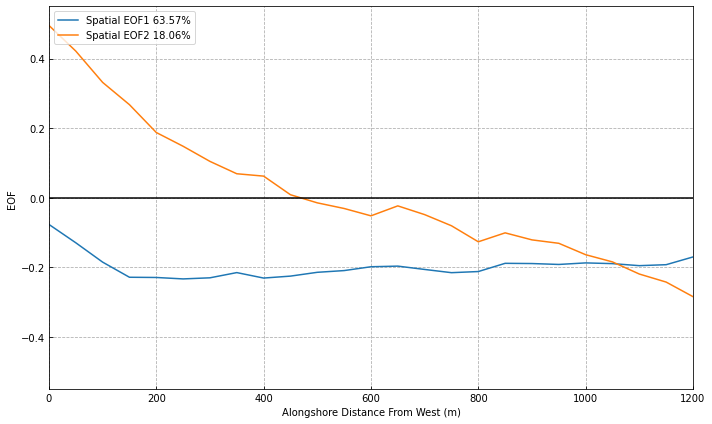

In [8]:
# Plot Spatial variability

# Plot Variables
numTransects = len(e_x)
xtickLabels = df.columns[::4]
xticks = np.arange(0, numTransects)[::4]

# Plotting
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)

for i in range(k):
    ax.plot(np.real(e_x[:,i]), label = f'Spatial EOF{i+1} {np.round(pOfVar[i], 2)}%')
ax.legend(loc = labelLoc)
ax.axhline(0, color = 'k')
ax.tick_params(direction="in")

plt.xticks(xticks, labels = xtickLabels)
plt.xlabel(xTitle)
plt.ylabel(yTitle)
plt.ylim(yRange)
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid(ls = '--')

plt.savefig(plotName, dpi = resolution)

[]

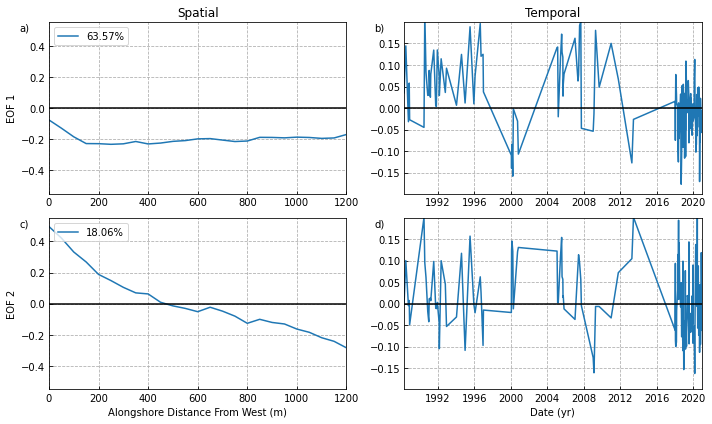

In [9]:
fig, axes = plt.subplots(nrows = k, ncols = 2, figsize = figSize, tight_layout = True)
numTransects = len(e_x)
xtickLabels = df.columns[::4]
xticks = np.arange(0, numTransects)[::4]

for i in range(k):
    axes[i,0].plot(np.real(e_x[:,i]), label = f'{np.round(pOfVar[i], 2)}%')
    axes[i,0].set_ylabel(f'EOF {i+1}')
    axes[i,0].set_ylim(yRange)
    axes[i,0].legend(loc = labelLoc)
    axes[i,1].plot(df2.index, np.real(c_t[:,i]), label = f'{np.round(pOfVar[i], 2)}%')
    axes[i,1].set_ylim(yRangeTemp) 
    for j in range(2):
        axes[i,j].autoscale(enable = True, axis ='x', tight = True)
        axes[i,j].axhline(0, color = 'k')
        axes[i,j].tick_params(direction="in")
        axes[i,j].text(-0.1, 0.95, labelLetters[i][j], transform=axes[i,j].transAxes)
        axes[i,j].grid(ls = '--')
    axes[i,0].set_xticks(xticks)
    axes[i,0].set_xticklabels(xtickLabels)
    

# Spatial and Temporal Titles
for ax, col in zip(axes[0], colTitles):
    ax.set_title(col)
axes[1,0].set_xlabel(xTitle)
axes[1,1].set_xlabel('Date (yr)')



plt.savefig(plot2Name, dpi = resolution)
plt.plot()

In [10]:
c_t1 = np.real(c_t[:,0])
c_t2 = np.real(c_t[:,1])
c_t3 = np.real(c_t[:,2])

df2['c_t1'] = c_t1
df2['c_t2'] = c_t2
df2['c_t3'] = c_t3
df2.to_csv(dataDir + 'eofs_SAM_Neg.csv')

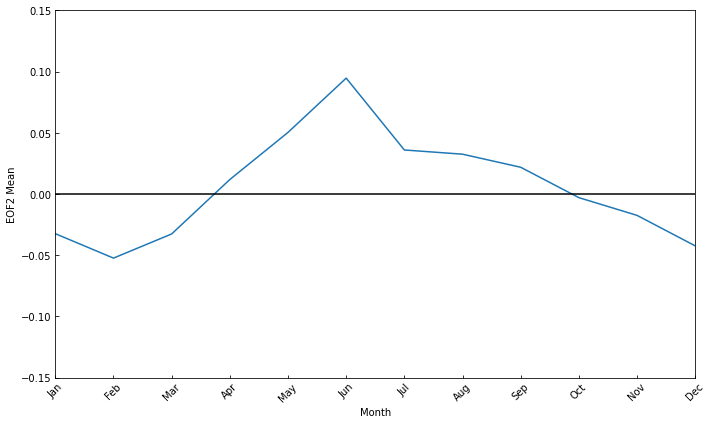

In [11]:
xtickMonths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Monthly averages of "rotation" variability
fig, ax = plt.subplots(figsize = figSize, tight_layout = True)

ax.plot(df2.groupby(df2.index.month)['c_t2'].mean())
ax.axhline(0, color = 'k')
ax.tick_params(direction="in")
ax.autoscale(enable = True, axis ='x', tight = True)
plt.xticks(range(1,13), labels = xtickMonths, rotation = 45)
plt.xlabel('Month')
plt.ylabel('EOF2 Mean')
plt.ylim(-0.15, 0.15)
plt.savefig(dataDir + plotDir + 'rotationEOF_SAM_Neg.jpg', dpi = resolution)
plt.show()

# The End